In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# Set seed for PyTorch (CPU & CUDA)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)  # For multi-GPU

import json
import matplotlib.pyplot as plt

from mobilenet import MobileNet
from data import get_train_valid_loader, get_test_loader

In [2]:
def train_func(model, optimizer, criterion, train_loader, device, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total

    return train_loss, train_accuracy

def eval(model, criterion, test_loader, device):
    # Evaluate the model on the validation set
    model.eval()
    valid_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    valid_loss = valid_loss / len(valid_loader)
    valid_accuracy = 100 * correct / total

    return valid_loss, valid_accuracy


In [3]:
batch_size = 128
data_dir = './data'
train_loader, valid_loader = get_train_valid_loader(data_dir=data_dir,batch_size=batch_size,augment=True,random_seed=42)
test_loader = get_test_loader(data_dir=data_dir, batch_size=batch_size)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Running experiment with learning rate: 0.2
Epoch [1/15], Train Loss: 4.4919, Train Acc: 2.65%, Valid Loss: 4.2425, Valid Acc: 3.57%
Epoch [11/15], Train Loss: 2.1491, Train Acc: 41.35%, Valid Loss: 2.3963, Valid Acc: 38.42%
Epoch [15/15], Train Loss: 1.8360, Train Acc: 48.58%, Valid Loss: 2.0899, Valid Acc: 44.42%


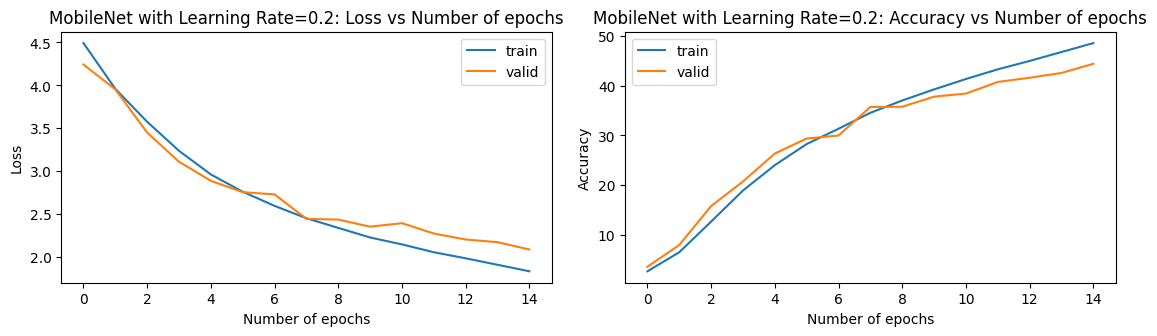

Running experiment with learning rate: 0.05
Epoch [1/15], Train Loss: 4.1995, Train Acc: 5.87%, Valid Loss: 3.7970, Valid Acc: 10.91%
Epoch [11/15], Train Loss: 1.8927, Train Acc: 47.23%, Valid Loss: 2.0550, Valid Acc: 44.64%
Epoch [15/15], Train Loss: 1.5949, Train Acc: 54.62%, Valid Loss: 1.8900, Valid Acc: 48.88%


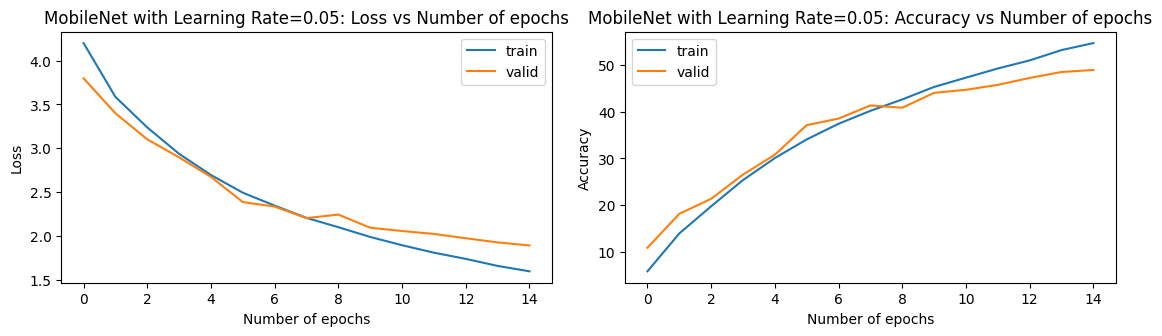

Running experiment with learning rate: 0.01
Epoch [1/15], Train Loss: 4.1305, Train Acc: 6.11%, Valid Loss: 3.7363, Valid Acc: 10.86%
Epoch [11/15], Train Loss: 1.9801, Train Acc: 45.95%, Valid Loss: 2.0999, Valid Acc: 43.96%
Epoch [15/15], Train Loss: 1.7021, Train Acc: 52.30%, Valid Loss: 1.9472, Valid Acc: 47.54%


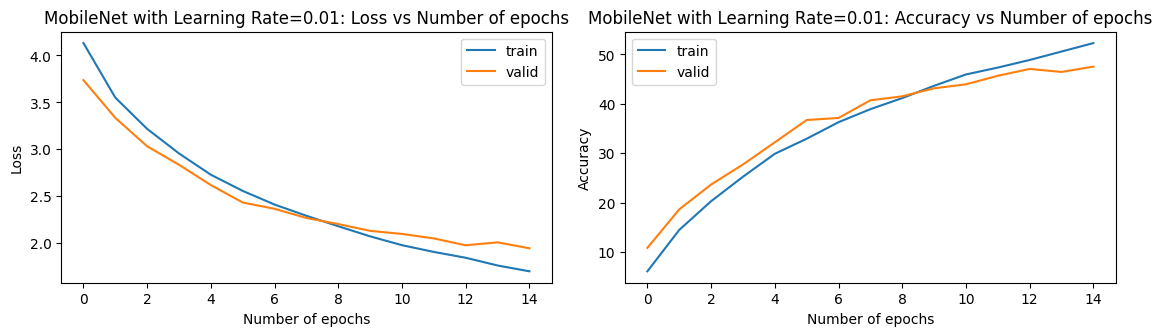

In [4]:
# prompt:  Run three experiments with the learning rate set to 0.2, 0.05, and 0.01 respectively. The batch size should be set to 128.  Train the networks for 15 epochs under
# each setting.  You should draw the following diagrams: (1) training loss and validation loss against the number of epochs, and (2) training accuracy and validation accuracy against the number of epochs.


# Hyperparameters
num_epochs = 15
learning_rates = [0.2, 0.05, 0.01]
momentum = 0.9

# MobileNet model
model = MobileNet(num_classes=100, sigmoid_block_ind = []).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
for learning_rate in learning_rates:
    print(f"Running experiment with learning rate: {learning_rate}")
    model = MobileNet(num_classes=100).to(device)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []

    for epoch in range(num_epochs):
        # Train the model
        train_loss, train_accuracy = train_func(model, optimizer, criterion, train_loader, device, epoch)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Evaluate the model on the validation set
        valid_loss, valid_accuracy = eval(model, criterion, test_loader, device)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_accuracy)
        
        if epoch % 10 == 0 or epoch == num_epochs-1:
            print(f"Epoch [{epoch+1}/{num_epochs}], "
                f"Train Loss: {train_loss:.4f}, "
                f"Train Acc: {train_accuracy:.2f}%, "
                f"Valid Loss: {valid_loss:.4f}, "
                f"Valid Acc: {valid_accuracy:.2f}%")

    # plt.tight_layout()
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(len(train_losses)), train_losses)
    plt.plot(range(len(valid_losses)), valid_losses)
    plt.xlabel("Number of epochs")
    plt.ylabel("Loss")
    plt.title(f"MobileNet with Learning Rate={learning_rate}: Loss vs Number of epochs")
    plt.legend(['train', 'valid'])
    # plt.savefig(f'images/{learning_rate}_loss.png')
    # plt.show()

    plt.subplot(1, 2, 2)
    plt.tight_layout(pad = 3)
    plt.plot(range(len(train_accuracies)), train_accuracies)
    plt.plot(range(len(valid_accuracies)), valid_accuracies)
    plt.xlabel("Number of epochs")
    plt.ylabel("Accuracy")
    plt.title(f"MobileNet with Learning Rate={learning_rate}: Accuracy vs Number of epochs")
    plt.legend(['train', 'valid'])
    plt.savefig(f'images/{learning_rate}_curves.png')
    plt.show()

    learning_curves = {"train_losses": train_losses,
                        "valid_losses": valid_losses,
                        "train_accuracies": train_accuracies,
                        "valid_accuracies": valid_accuracies
                        }
    
    with open(f'learning_curves/{learning_rate}.json', 'w') as fp:
        json.dump(learning_curves, fp)

Experiment 1: Training with constant learning rate
Epoch [1/300], Train Loss: 4.1318, Train Acc: 6.62%, Valid Loss: 3.7093, Valid Acc: 11.47%
Epoch [2/300], Train Loss: 3.4950, Train Acc: 15.62%, Valid Loss: 3.2775, Valid Acc: 19.74%
Epoch [3/300], Train Loss: 3.1696, Train Acc: 21.43%, Valid Loss: 2.9731, Valid Acc: 24.91%
Epoch [4/300], Train Loss: 2.9218, Train Acc: 26.12%, Valid Loss: 2.7697, Valid Acc: 28.68%
Epoch [5/300], Train Loss: 2.6959, Train Acc: 30.37%, Valid Loss: 2.5612, Valid Acc: 33.72%
Epoch [6/300], Train Loss: 2.5330, Train Acc: 33.90%, Valid Loss: 2.4652, Valid Acc: 35.60%
Epoch [7/300], Train Loss: 2.3725, Train Acc: 37.19%, Valid Loss: 2.3271, Valid Acc: 39.18%
Epoch [8/300], Train Loss: 2.2641, Train Acc: 39.39%, Valid Loss: 2.2407, Valid Acc: 39.95%
Epoch [9/300], Train Loss: 2.1457, Train Acc: 42.22%, Valid Loss: 2.1978, Valid Acc: 41.04%
Epoch [10/300], Train Loss: 2.0446, Train Acc: 44.35%, Valid Loss: 2.1429, Valid Acc: 42.58%
Epoch [11/300], Train Loss: 1

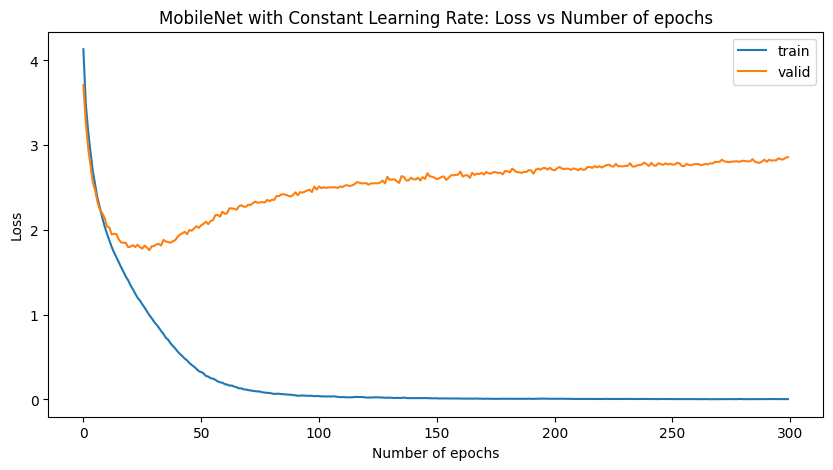

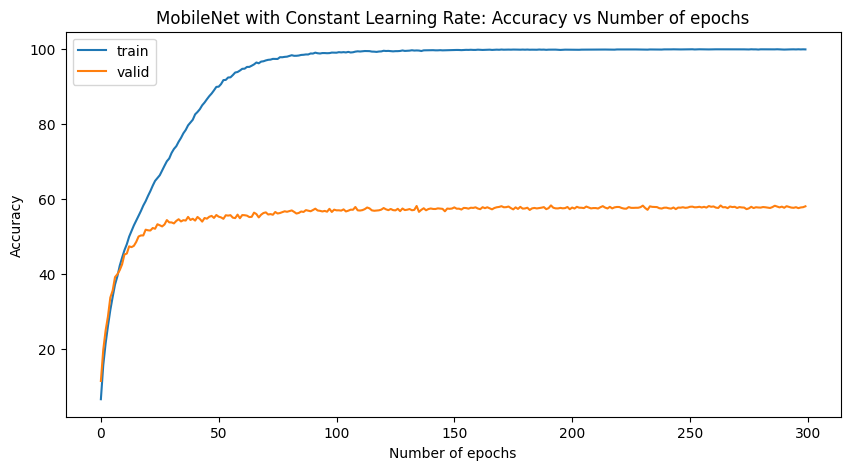

In [5]:
# Hyperparameters for the new experiments
num_epochs = 300
learning_rate = 0.01 

# Function to train with constant learning rate
def train_constant_lr(model, optimizer, criterion, train_loader, valid_loader, device, num_epochs):
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train_func(model, optimizer, criterion, train_loader, device, epoch)
        valid_loss, valid_accuracy = eval(model, criterion, valid_loader, device)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_accuracies.append(train_accuracy)
        valid_accuracies.append(valid_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {train_loss:.4f}, "
              f"Train Acc: {train_accuracy:.2f}%, "
              f"Valid Loss: {valid_loss:.4f}, "
              f"Valid Acc: {valid_accuracy:.2f}%")

    return train_losses, valid_losses, train_accuracies, valid_accuracies



# Experiment 1: Train for 300 epochs with constant learning rate
print("Experiment 1: Training with constant learning rate")
model = MobileNet(num_classes=100).to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
train_losses, valid_losses, train_accuracies, valid_accuracies = train_constant_lr(
    model, optimizer, criterion, train_loader, valid_loader, device, num_epochs)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(len(train_losses)), train_losses)
plt.plot(range(len(valid_losses)), valid_losses)
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.title("MobileNet with Constant Learning Rate: Loss vs Number of epochs")
plt.legend(['train', 'valid'])
plt.savefig('images/constant_lr_loss.png')
plt.show()

plt.subplot(1, 2, 2)
plt.tight_layout(pad = 3)
plt.plot(range(len(train_accuracies)), train_accuracies)
plt.plot(range(len(valid_accuracies)), valid_accuracies)
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.title("MobileNet with Constant Learning Rate: Accuracy vs Number of epochs")
plt.legend(['train', 'valid'])
plt.savefig('images/constant_lr_accuracy.png')
plt.show()

In [6]:
learning_curves_constant_lr = {  
                                        "train_losses": train_losses,
                                        "valid_losses": valid_losses,
                                        "train_accuracies": train_accuracies,
                                        "valid_accuracies": valid_accuracies
                                    }
with open('learning_curves_constant_lr.json', 'w') as fp:
    json.dump(learning_curves_constant_lr, fp)

Experiment 2: Training with cosine annealing learning rate
Epoch [1/300], Train Loss: 4.1590, Train Acc: 6.19%, Valid Loss: 3.7240, Valid Acc: 11.44%Learning Rate: 0.010000
Epoch [2/300], Train Loss: 3.5119, Train Acc: 15.30%, Valid Loss: 3.2904, Valid Acc: 19.11%Learning Rate: 0.009999
Epoch [3/300], Train Loss: 3.1892, Train Acc: 20.71%, Valid Loss: 3.0054, Valid Acc: 24.03%Learning Rate: 0.009998
Epoch [4/300], Train Loss: 2.9357, Train Acc: 25.64%, Valid Loss: 2.7334, Valid Acc: 30.44%Learning Rate: 0.009996
Epoch [5/300], Train Loss: 2.7185, Train Acc: 30.06%, Valid Loss: 2.5935, Valid Acc: 33.10%Learning Rate: 0.009993
Epoch [6/300], Train Loss: 2.5326, Train Acc: 33.58%, Valid Loss: 2.4310, Valid Acc: 35.78%Learning Rate: 0.009990
Epoch [7/300], Train Loss: 2.3864, Train Acc: 36.61%, Valid Loss: 2.3282, Valid Acc: 38.51%Learning Rate: 0.009987
Epoch [8/300], Train Loss: 2.2667, Train Acc: 39.39%, Valid Loss: 2.2705, Valid Acc: 40.49%Learning Rate: 0.009982
Epoch [9/300], Train L

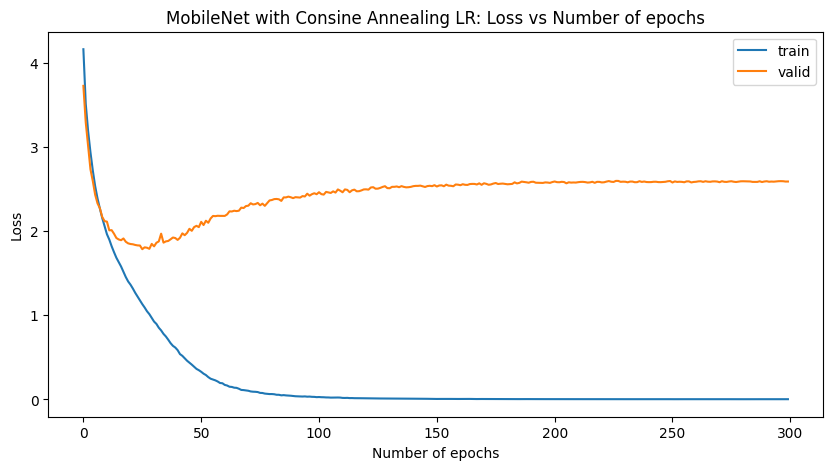

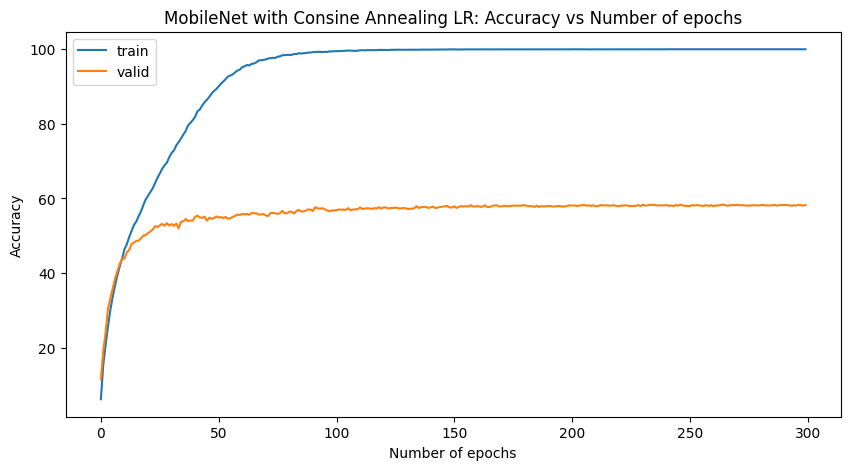

In [8]:
# Function to train with cosine annealing learning rate
def train_cosine_annealing(model, initial_lr, criterion, train_loader, valid_loader, device, num_epochs):
    optimizer = optim.SGD(model.parameters(), lr=initial_lr, momentum=momentum)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train_func(model, optimizer, criterion, train_loader, device, epoch)
        valid_loss, valid_accuracy = eval(model, criterion, valid_loader, device)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_accuracies.append(train_accuracy)
        valid_accuracies.append(valid_accuracy)

        scheduler.step()
        
        # Get the current learning rate
        current_lr = scheduler.get_last_lr()[0]  # Extract current learning rate
        
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {train_loss:.4f}, "
              f"Train Acc: {train_accuracy:.2f}%, "
              f"Valid Loss: {valid_loss:.4f}, "
              f"Valid Acc: {valid_accuracy:.2f}%"
              f"Learning Rate: {current_lr:.6f}")

    return train_losses, valid_losses, train_accuracies, valid_accuracies
    
# Experiment 2: Train for 300 epochs with cosine annealing learning rate
print("Experiment 2: Training with cosine annealing learning rate")
model = MobileNet(num_classes=100).to(device)
train_losses, valid_losses, train_accuracies, valid_accuracies = train_cosine_annealing(
    model, learning_rate, criterion, train_loader, valid_loader, device, num_epochs)

plt.figure(figsize=(10, 5))
plt.plot(range(len(train_losses)), train_losses)
plt.plot(range(len(valid_losses)), valid_losses)
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.title("MobileNet with Consine Annealing LR: Loss vs Number of epochs")
plt.legend(['train', 'valid'])
plt.savefig('images/cosine_annealing_loss.png')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(len(train_accuracies)), train_accuracies)
plt.plot(range(len(valid_accuracies)), valid_accuracies)
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.title("MobileNet with Consine Annealing LR: Accuracy vs Number of epochs")
plt.legend(['train', 'valid'])
plt.savefig('images/cosine_annealing_accuracy.png')
plt.show()

In [9]:
learning_curves_cosine_annealing = {"train_losses": train_losses,
                                "valid_losses": valid_losses,
                                "train_accuracies": train_accuracies,
                                "valid_accuracies": valid_accuracies
                                    }
with open('learning_curves_cosine_annealing.json', 'w') as fp:
    json.dump(learning_curves_cosine_annealing, fp)

In [13]:
# Hyperparameters for the new experiment
num_epochs = 300
learning_rate = 0.01
weight_decay = 1e-4
momentum = 0.9

# Function to train with weight decay and cosine annealing learning rate
def train_weight_decay_cosine_annealing(model, initial_lr, weight_decay, criterion, train_loader, valid_loader, device, num_epochs):
    optimizer = optim.SGD(model.parameters(), lr=initial_lr, momentum=momentum, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train_func(model, optimizer, criterion, train_loader, device, epoch)
        valid_loss, valid_accuracy = eval(model, criterion, valid_loader, device)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_accuracies.append(train_accuracy)
        valid_accuracies.append(valid_accuracy)

        scheduler.step()
        
        # Get the current learning rate
        current_lr = scheduler.get_last_lr()[0]  # Extract current learning rate
        
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {train_loss:.4f}, "
              f"Train Acc: {train_accuracy:.2f}%, "
              f"Valid Loss: {valid_loss:.4f}, "
              f"Valid Acc: {valid_accuracy:.2f}%, "
              f"Learning Rate: {current_lr:.6f}")

    return train_losses, valid_losses, train_accuracies, valid_accuracies
    
# Experiment: Train for 300 epochs with weight decay and cosine annealing learning rate
print("Experiment: Training with weight decay and cosine annealing learning rate")
# MobileNet model
model = MobileNet(num_classes=100).to(device)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
train_losses, valid_losses, train_accuracies, valid_accuracies = train_weight_decay_cosine_annealing(
    model, learning_rate, weight_decay, criterion, train_loader, valid_loader, device, num_epochs)

plt.figure(figsize=(10, 5))
plt.plot(range(len(train_losses)), train_losses)
plt.plot(range(len(valid_losses)), valid_losses)
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.title("MobileNet with Weight Decay and Cosine Annealing LR: Loss vs Number of epochs")
plt.legend(['train', 'valid'])
plt.savefig('images/weight_decay_cosine_annealing_loss_1e4.png')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(len(train_accuracies)), train_accuracies)
plt.plot(range(len(valid_accuracies)), valid_accuracies)
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.title("MobileNet with Weight Decay and Cosine Annealing LR: Accuracy vs Number of epochs")
plt.legend(['train', 'valid'])
plt.savefig('images/weight_decay_cosine_annealing_accuracy_1e4.png')
plt.show()


learning_curves_cosine_annealing_weight_decay = {"train_losses": train_losses,
                                "valid_losses": valid_losses,
                                "train_accuracies": train_accuracies,
                                "valid_accuracies": valid_accuracies
                                    }
with open('learning_curves_cosine_annealing_weight_decay_1e4.json', 'w') as fp:
    json.dump(learning_curves_cosine_annealing, fp)

Experiment: Training with weight decay and cosine annealing learning rate
Epoch [1/300], Train Loss: 4.1297, Train Acc: 6.10%, Valid Loss: 3.7001, Valid Acc: 11.60%, Learning Rate: 0.010000
Epoch [2/300], Train Loss: 3.4975, Train Acc: 15.48%, Valid Loss: 3.3249, Valid Acc: 18.08%, Learning Rate: 0.009999
Epoch [3/300], Train Loss: 3.1565, Train Acc: 21.62%, Valid Loss: 2.9490, Valid Acc: 25.96%, Learning Rate: 0.009998
Epoch [4/300], Train Loss: 2.8999, Train Acc: 26.32%, Valid Loss: 2.7711, Valid Acc: 28.50%, Learning Rate: 0.009996
Epoch [5/300], Train Loss: 2.6819, Train Acc: 30.97%, Valid Loss: 2.5647, Valid Acc: 33.01%, Learning Rate: 0.009993
Epoch [6/300], Train Loss: 2.5128, Train Acc: 34.26%, Valid Loss: 2.4745, Valid Acc: 35.59%, Learning Rate: 0.009990
Epoch [7/300], Train Loss: 2.3715, Train Acc: 37.08%, Valid Loss: 2.3131, Valid Acc: 39.01%, Learning Rate: 0.009987
Epoch [8/300], Train Loss: 2.2430, Train Acc: 40.05%, Valid Loss: 2.2293, Valid Acc: 40.69%, Learning Rate: 

Exception ignored in: <function _releaseLock at 0x7f4d37fb2cb0>
Traceback (most recent call last):
  File "/usr/lib/python3.10/logging/__init__.py", line 228, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 


RuntimeError: DataLoader worker (pid(s) 7622, 7623) exited unexpectedly

In [ ]:
def test_accuracy(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# Calculate accuracy on the test set
test_acc = test_accuracy(model, test_loader, device)
print(f"Accuracy of the model on the hold-out test set: {test_acc:.2f}%")